In [1]:
from tool import *
def fill_albedo2(month,type,sza_L,interp_2000=False):
    max_distance=3
    distence_w_dim=torch.load(root_path+'information_val2/weights.pth')[type]
    sza_L_month=sza_L[0,month-1]
    # distence_w_dim=[1,1,1,1]
    bands=['albedo_BSA_vis', 
        'albedo_WSA_vis', 
        'albedo_BSA_nir', 
        'albedo_WSA_nir', 
        'albedo_BSA_shortwave', 
        'albedo_WSA_shortwave']
    # band='albedo_BSA_vis'

    # m_index=[(month-3)%12+1,(month-2)%12+1,(month-1)%12+1,(month)%12+1,(month+1)%12+1]
    m_index=[(month-2)%12+1,(month-1)%12+1,(month)%12+1]
    offset=[1 if m_index[j]-m_index[0]>=0 else -1 for j in range(len(m_index))]
    if np.array(offset).sum()==len(offset):
        offset=[0]*len(m_index)
    # print(month,m_index,offset)

    vs=[]
    ms=[]
    land_proportions=[]
    for i in range(len(offset)):    
        NC=nc.Dataset(root_path+f'information_temp/month_{m_index[i]}.nc','r')
        for band in bands:
            vs.append(NC.variables[f'{band}-{type}'][:])
        if type!='ocean':
            ms.append(NC.variables[f'area-{type}'][:])
        # qa=NC.variables['qa'][:]
        area_grid=NC.variables['area-grid'][:]
        area_land=NC.variables['area-land'][:]
        land_proportions.append(area_land/area_grid)
        NC.close()
    offset_bands=[]
    for i in offset:
        offset_bands+=[i]*len(bands)
    if offset[0]!=0:
        nan_array=np.zeros((1,180,360))*np.nan
        vs=[np.concatenate((nan_array,vs[i]),axis=0) if offset_bands[i]==1 else np.concatenate((vs[i],nan_array),axis=0) for i in range(len(offset_bands))]
        land_proportions=[np.concatenate((nan_array,land_proportions[i]),axis=0) if offset[i]==1 else np.concatenate((land_proportions[i],nan_array),axis=0) for i in range(len(offset))]
        if type!='ocean':
            ms=[np.concatenate((nan_array,ms[i]),axis=0) if offset[i]==1 else np.concatenate((ms[i],nan_array),axis=0) for i in range(len(offset))]
        else:
            ms=land_proportions  
    else:
        if type=='ocean':
            ms=land_proportions  
    M,H,W=vs[0].shape
    v=np.stack(vs).reshape((len(offset),len(bands),M,H,W)).transpose((1,0,2,3,4))#(6, 3, 21, 180, 360)

    # vv=[v[:,i] for i in range(len(bands))]
    m=np.stack(ms)
    # plt.imshow(v[0,1,1])
    # plt.show()
    # land_proportion=np.stack(land_proportions)
    # print(month,m_index,v.shape)
    all_indices = np.indices(v[0].shape).reshape(4, -1).T
    
    

    
    
    if interp_2000:
        if type!='ocean':
                interp_indices = all_indices[((v[0]==2000) & (m>0)).reshape(-1)]
        else:
            interp_indices = all_indices[((v[0]==2000) & (m<1) & (m>0)).reshape(-1)]
        nonan_indices=all_indices[((~np.isnan(v[0])).reshape(-1)) & ((v[0]!=2000).reshape(-1))]
    else:
    
        if type!='ocean':
            interp_indices = all_indices[(np.isnan(v[0]) & (m>0)).reshape(-1)]
        else:
            interp_indices = all_indices[(np.isnan(v[0]) & (m<1) & (m>0)).reshape(-1)]
        nonan_indices=all_indices[(~np.isnan(v[0])).reshape(-1)]
    
    
    
    
    # print(len(nonan_indices))
    interp_indices=[j for j in interp_indices if j[0]==int(len(offset)/2)]  
    interp_indices=[j for j in interp_indices if sza_L_month[j[2],j[3]]<2] #只插值天顶角小于85的
    nonan_indices2=[j for j in nonan_indices if j[0]==int(len(offset)/2)]  
    nonan_indices2=[j for j in nonan_indices2 if sza_L_month[j[2],j[3]]<2]
    # interp_values=[]
    # search_n=1
    # print(month,type,len(interp_indices),round(len(interp_indices)/(len(nonan_indices)+len(interp_indices))*100,2),'%')
    str_output=f'{month}-{type}  '+str(len(interp_indices))+'  '+str(round(len(interp_indices)/(len(nonan_indices2)+len(interp_indices)+0.01)*100,2))+'%'
    # for interp_indice in tqdm(interp_indices):
    #     k=TS_IDM_4d(interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim)
    #     while np.isnan(k):
    #         search_n*=2
    #         k=TS_IDM_4d(interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim)

    #     interp_values.append(k)
    time.sleep(1)
    kk=[search_nonan2(v,interp_indice,max_distance=max_distance,distence_w_dim=distence_w_dim,interp_2000=interp_2000) for interp_indice in tqdm(interp_indices,desc=str_output)]
    interp_values=np.array([a[0] for a in kk])
    dws=np.array([a[1] for a in kk])
    # print('fill value '+str((1-np.isnan(interp_values).sum()/interp_values.shape[0])*100)+'%')
    dws_v=np.zeros(v.shape)
    for z in range(len(interp_indices)):
        v[:,interp_indices[z][0],interp_indices[z][1],interp_indices[z][2],interp_indices[z][3]]=np.array(interp_values[z])
        dws_v[:,interp_indices[z][0],interp_indices[z][1],interp_indices[z][2],interp_indices[z][3]]=np.array(dws[z])
    # print(v.shape,dws_v.shape)
    if offset[int(len(offset)/2)]>=0:
        return v[:,int(len(offset)/2),offset[int(len(offset)/2)]:],dws_v[:,int(len(offset)/2),offset[int(len(offset)/2)]:]
    else:
        return v[:,int(len(offset)/2),:-1],dws_v[:,int(len(offset)/2),:-1]
def TS_IDM_4d_2(v,interp_indice,max_distance,distence_w_dim,interp_2000):
    
        value=v[zero(interp_indice[0]-int(max_distance/distence_w_dim[0])):interp_indice[0]+int(max_distance/distence_w_dim[0])+1,
                zero(interp_indice[1]-int(max_distance/distence_w_dim[1])):interp_indice[1]+int(max_distance/distence_w_dim[1])+1,
                zero(interp_indice[2]-int(max_distance/distence_w_dim[2])):interp_indice[2]+int(max_distance/distence_w_dim[2])+1,
                zero(interp_indice[3]-int(max_distance/distence_w_dim[3])):interp_indice[3]+int(max_distance/distence_w_dim[3])+1]
        non_nan_indices = np.where(~np.isnan(value))
        
        
        if interp_2000:
            v[v==2000]=np.nan
        
        
        non_nan_points = np.array(list(zip(non_nan_indices[0], non_nan_indices[1], non_nan_indices[2],non_nan_indices[3])))
         
        if len(non_nan_points)==0:
                interpolated_value=np.nan
                dws=np.nan
        else:
                k=np.array([zero(-interp_indice[0]+int(max_distance/distence_w_dim[0]))-int(max_distance/distence_w_dim[0]),
                        zero(-interp_indice[1]+int(max_distance/distence_w_dim[1]))-int(max_distance/distence_w_dim[1]),
                        zero(-interp_indice[2]+int(max_distance/distence_w_dim[2]))-int(max_distance/distence_w_dim[2]),
                        zero(-interp_indice[3]+int(max_distance/distence_w_dim[3]))-int(max_distance/distence_w_dim[3])])
                # print(k)
                # print(non_nan_points)
                non_nan_points+=k
                distance_s = np.array([np.linalg.norm(np.array(non_nan_points[i])*np.array(distence_w_dim)) for i in range(len(non_nan_points))])
                if len(distance_s)<10:
                        interpolated_value=np.nan
                        dws=np.nan
                else:
                        kth = np.partition(distance_s, 9)[9]
                        distance=distance_s.copy()
                        distance1=distance_s.copy()
                        distance1=distance1[distance_s<=kth]
                        weights = 1.0 / distance1**2
                        dws=np.sum(weights)
                        weights /= dws
                        non_nan_values = value[non_nan_indices]
                        non_nan_values=non_nan_values[distance<=kth]
                        interpolated_value = np.sum(weights * non_nan_values)
        return interpolated_value,dws
    
def search_nonan2(v,interp_indice,max_distance,distence_w_dim,interp_2000):
    k_bands=[]
    dws_bands=[]
    search_n=1
    for i in range(6):
        k,dws=TS_IDM_4d_2(v[i],interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim[i],interp_2000=interp_2000)
        while np.isnan(k):
            search_n*=2
            k,dws=TS_IDM_4d_2(v[i],interp_indice,max_distance=max_distance*search_n,distence_w_dim=distence_w_dim[i],interp_2000=interp_2000)
        k_bands.append(k)
        dws_bands.append(dws)
    
    return k_bands,dws_bands
def zero(k):
    if k<0:
        return 0
    else:
        return k

In [2]:
#fill albedo
bands=['albedo_BSA_vis', 
'albedo_WSA_vis', 
'albedo_BSA_nir', 
'albedo_WSA_nir', 
'albedo_BSA_shortwave',
'albedo_WSA_shortwave']
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')
landtypes=['landtype'+str(i) for i in range(1,18)]+['snow']
for month in [4,5,6]:
    NC=nc.Dataset(root_path+f'information_val3/month_{month}.nc','r+')
    for type in landtypes:
        v_fill,dws=fill_albedo2(month,type,sza_L,True)
        for band_i in range(len(bands)):
            NC.variables[f'{bands[band_i]}-{type}'][:]=v_fill[band_i]
            try:
                NC.createVariable(f'DWS-{type}-{bands[band_i]}', 'f4', ("time", "latitude", "longitude"))
            except:
                pass
                # print(f'DWS-{type}-{bands[band_i]} have existed')
            NC.variables[f'DWS-{type}-{bands[band_i]}'][:]=dws[band_i]
    NC.close()

4-landtype14  1646  1.91%: 100%|██████████| 1646/1646 [00:32<00:00, 50.95it/s]
4-landtype15  0  0.0%: 0it [00:00, ?it/s]
5-landtype14  1462  1.7%: 100%|██████████| 1462/1462 [00:23<00:00, 62.63it/s]
5-landtype15  0  0.0%: 0it [00:00, ?it/s]
6-landtype14  1303  1.52%: 100%|██████████| 1303/1303 [00:18<00:00, 68.77it/s] 
6-landtype15  0  0.0%: 0it [00:00, ?it/s]
6-snow  8000  7.21%: 100%|██████████| 8000/8000 [01:29<00:00, 89.39it/s] 


In [4]:
from tool import *
data=torch.load(root_path+'white_sky_fraction/white_sky_fraction.pth')

In [5]:
for b in range(240):
    data[b]

(240, 180, 360)

In [11]:
# def tif_save_snowfre(img,save_name,trf,p='4326',novalue=None,valuetype=6):
from tool import *
global_trf=(-180.5, 1, 0.0, 90.5, 0.0, -1)
save_name=root_path+'white_sky_fraction/white_sky_fraction.tif'
driver=gdal.GetDriverByName('GTiff')
new_img=driver.Create(save_name,data.shape[2],data.shape[1],data.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
new_img.SetGeoTransform(global_trf)
sref = osr.SpatialReference()
sref.ImportFromEPSG(4326)
proj = sref.ExportToWkt()
new_img.SetProjection(proj)
for i in range(data.shape[0]):
    new_img.GetRasterBand(i+1).WriteArray(data[i])
new_img.FlushCache()
del new_img

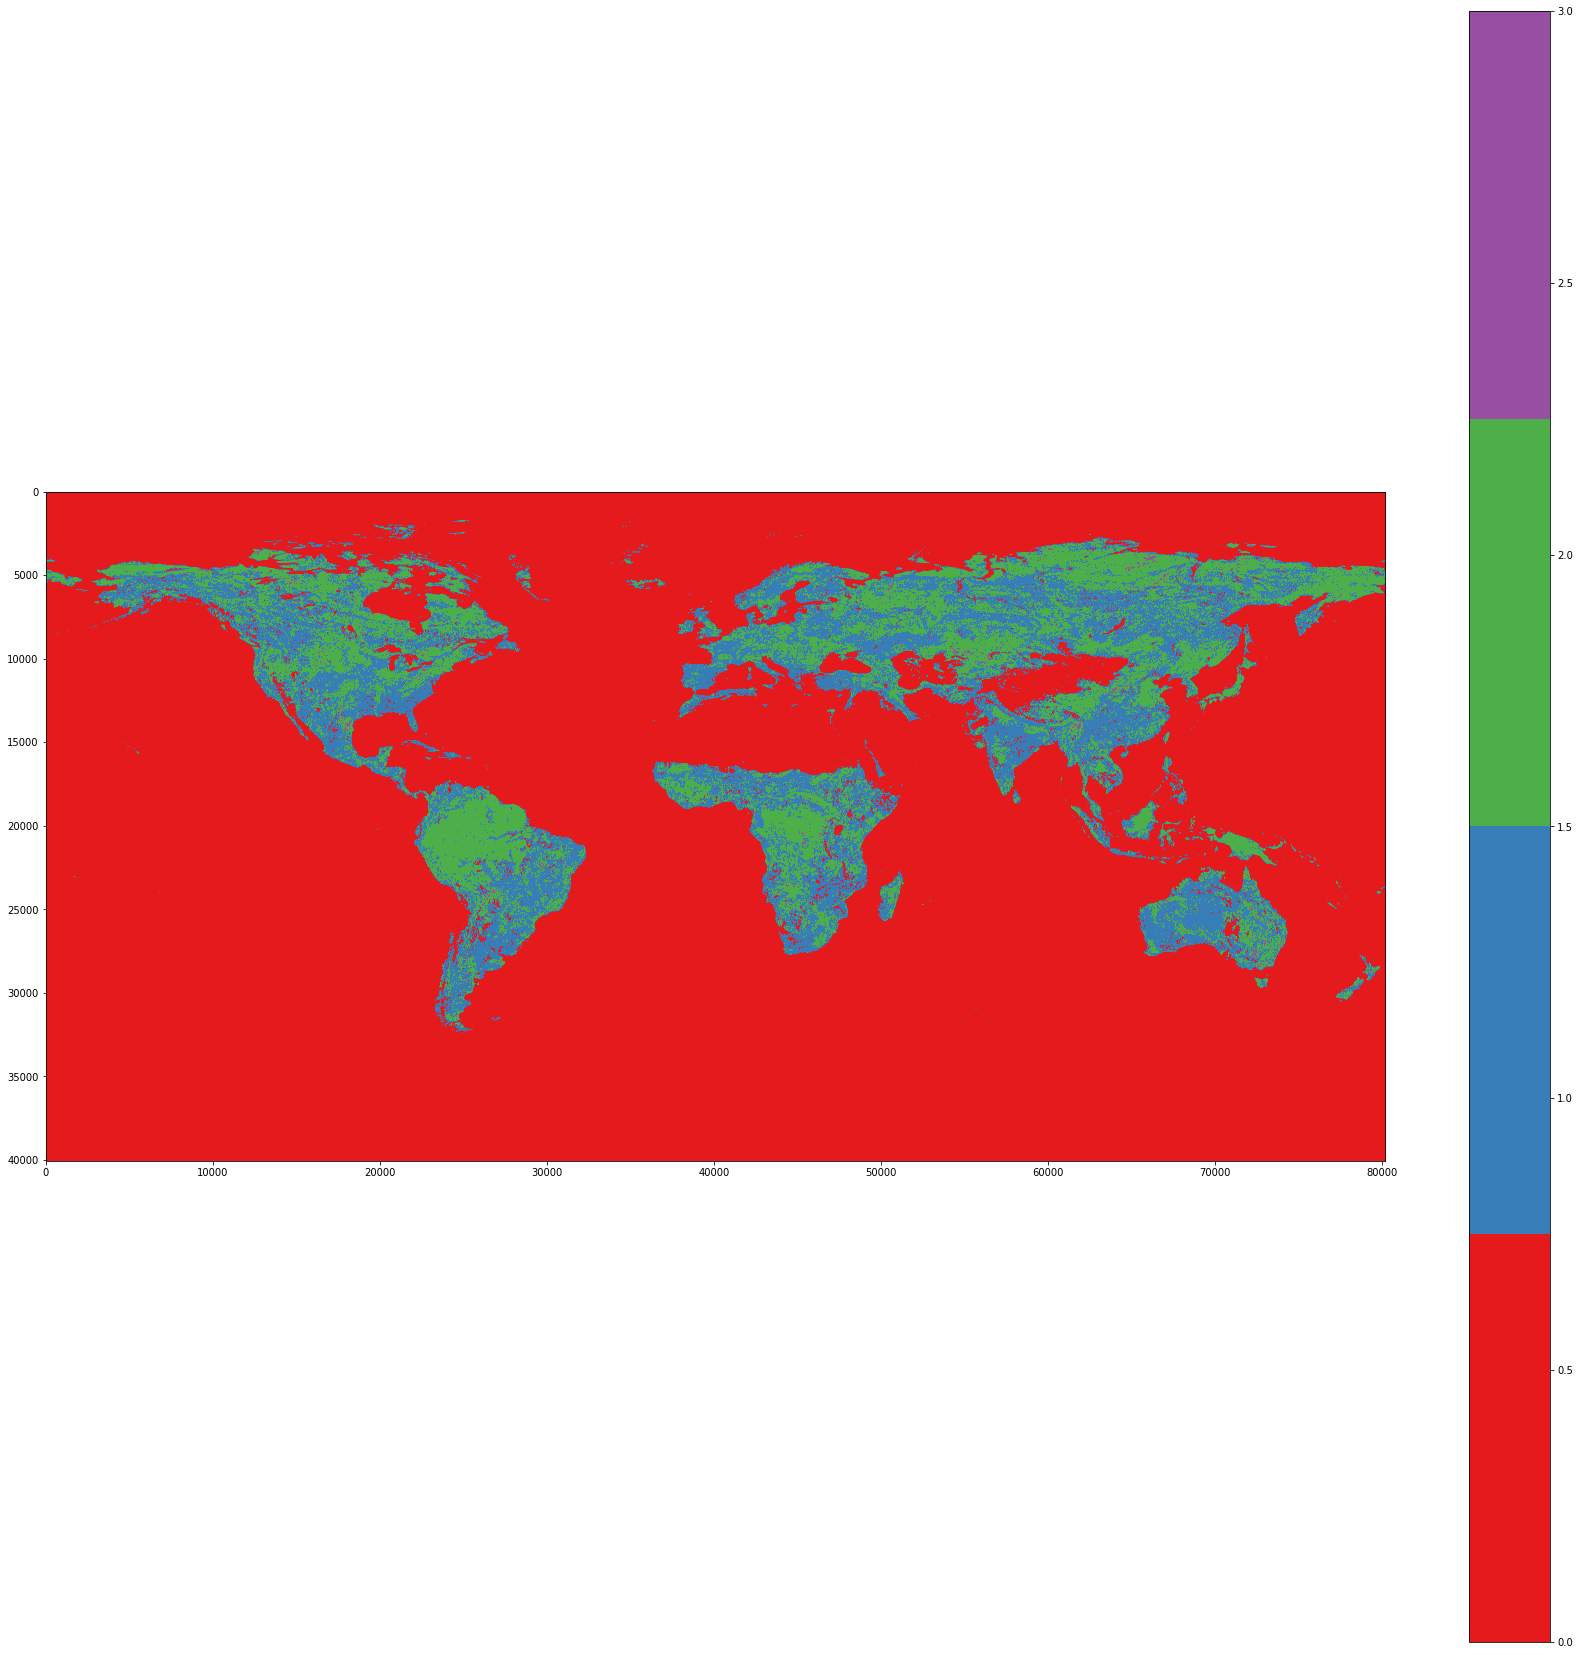

In [2]:
import matplotlib
from_list = matplotlib.colors.LinearSegmentedColormap.from_list
from tool import *
imgs_id=rasterio.open('/data2/hzy/ssd_hzy/figure_map/albedo2_map_maxid.tif').read(1)
plt.figure(figsize=(30,30))
cm = from_list('Set15', plt.cm.Set1(range(0,4)), 4)
plt.cm.register_cmap(None, cm)
plt.set_cmap(cm)
plt.imshow(imgs_id)
plt.colorbar()
plt.show()

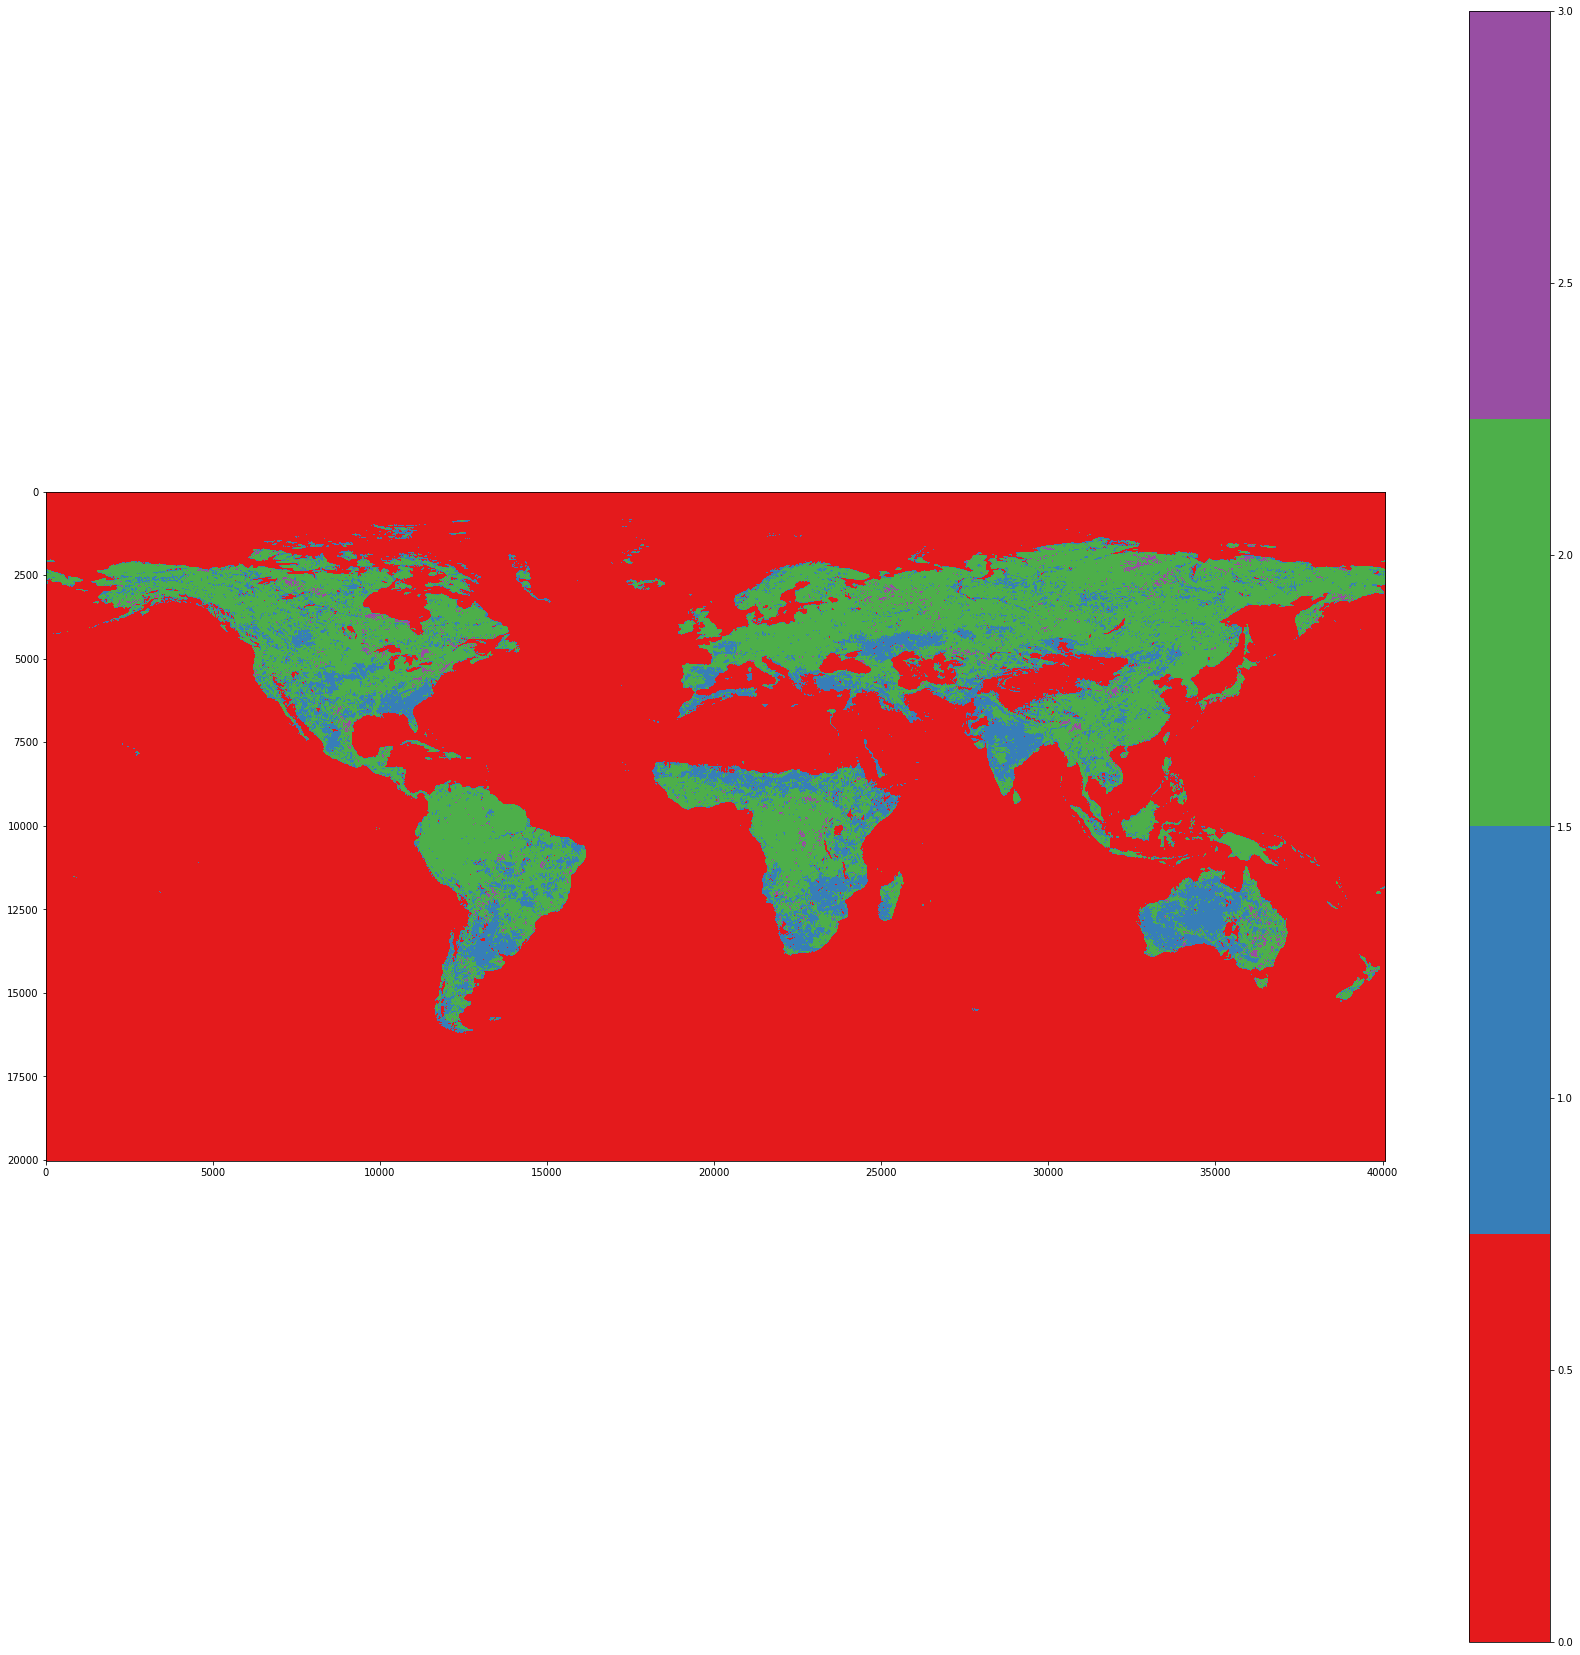

In [4]:
from tool import *
bb=['NDVI','SSI','NMDI']
imgs=[rasterio.open(f'/data2/hzy/ssd_hzy/figure_map/{b}_albedo2_map_1000m.tif').read(1) for b in bb]
imgs=np.stack(imgs,axis=0)
imgs=np.abs(imgs)
imgs_id=np.argmax(imgs,axis=0)
for i in range(3):
    imgs_id[imgs[i]==0]=4
imgs_id+=1
imgs_id[imgs_id==5]=0
new_trf=(global_trf[0]+global_trf[1],global_trf[1]*2,0,global_trf[3]+global_trf[5],0,global_trf[5]*2)
tif_save_snowfre(imgs_id,'/data2/hzy/ssd_hzy/figure_map/albedo_map_maxid_1000m.tif',new_trf,p='4326')
from tool import *
# imgs_id=rasterio.open(f'/ssd_hzy/G3/albedo2_map_maxid.tif').read(1)
import matplotlib
from_list = matplotlib.colors.LinearSegmentedColormap.from_list
plt.figure(figsize=(30,30))
cm = from_list('Set15', plt.cm.Set1(range(0,4)), 4)
plt.cm.register_cmap(None, cm)
plt.set_cmap(cm)
plt.imshow(imgs_id)
plt.colorbar()
plt.show()

In [1]:
from tool import *
from tool import *
def splice(files,output_file,pixel_size=0.0003,band_num=1,type='int32',masked=None):
    # print(files[0])
    MinX, MaxY, MaxX, MinY = get_extent(files[0])

    for fn in files[1:]:
        minX, maxY, maxX, minY = get_extent(fn)
        MinX = min(MinX, minX)
        MaxY = max(MaxY, maxY)
        MaxX = max(MaxX, maxX)
        MinY = min(MinY, minY)


    ds = gdal.Open(files[0])
    transform = ds.GetGeoTransform()
    pixelWidth = transform[1]
    pixelHeight = transform[5]
    #获取输出图像的行与列
    cols = int((MaxX - MinX) / pixel_size)
    rows = int((MaxY - MinY) / pixel_size)
    # print(cols)
    NP2GDAL_CONVERSION = {
      "uint8": 1,
      "int8": 1,
      "uint16": 2,
      "int16": 3,
      "uint32": 4,
      "int32": 5,
      "float32": 6,
      "float64": 7,
      "complex64": 10,
      "complex128": 11,
    }
    driver = gdal.GetDriverByName('GTiff')
    dsOut = driver.Create(output_file,
                            cols,rows,1,6,
                            ['COMPRESS=LZW','BIGTIFF=YES'])
    bandOut = dsOut.GetRasterBand(1)

    # 设置输出图像的几何信息和投影信息
    geotransform = [MinX, pixel_size, 0, MaxY, 0, pixel_size*(-1)]
    dsOut.SetGeoTransform(geotransform)
    dsOut.SetProjection(ds.GetProjection())
    # label=np.ones([rows,cols],dtype=type)*(-1001)
    label=np.zeros([rows,cols],dtype=type)
    n=0
    for fn in tqdm(files, desc=f'Band {band_num} '):
        ds = gdal.Open(fn)
        transform = ds.GetGeoTransform()
        pixelWidth = transform[1]
        pixelHeight = transform[5]

        rows = ds.RasterYSize
        cols = ds.RasterXSize
        transform = ds.GetGeoTransform()
        minX = transform[0]
        maxY = transform[3]
        pixelWidth = transform[1]
        pixelHeight = transform[5]#是负值（important）

        maxX = minX + (cols * pixelWidth)
        minY = maxY + (rows * pixelHeight)

        xOffset = round((minX - MinX) / pixel_size)
        yOffset = round((maxY - MaxY) / (pixel_size*(-1)))
        cols=int(cols*pixelWidth/pixel_size)
        rows=int(rows*pixelHeight/(pixel_size*(-1)))
        band = ds.GetRasterBand(band_num)
        # data = band.ReadAsArray(buf_xsize=cols,buf_ysize = rows)
        data = band.ReadAsArray()
        # data[np.isnan(data)]=-1001
        if masked is not None:
            data[data>=masked]=np.nan
        # print(data.max())
        label_part=label[yOffset:yOffset+rows,xOffset:xOffset+cols]
        # label_part2=label_part+data
        # label_part2[(label_part>0)&(data>0)]=np.maximum(data[(label_part>0)&(data>0)],label_part[(label_part>0)&(data2>0)])
        # label[yOffset:yOffset+rows,xOffset:xOffset+cols]=np.maximum(data,label_part)
        label[yOffset:yOffset+rows,xOffset:xOffset+cols]=data
        n+=1
        # print('\n拼接图像'+str(n))
    # print(label.max())
    # label[label==(-1001)]=np.nan
    # plt.imshow(label,vmin=-0.05,vmax=0.05,cmap='seismic')
    # plt.colorbar()
    # plt.show()
    # label[np.isnan(label)]=0
    # label[label>=1000]=1000
    # label[label<=-1000]=-1000
    # label*=100
    # label=label.astype('int32')
    dsOut.GetRasterBand(1).WriteArray(label)
    dsOut.FlushCache()
    del dsOut

In [2]:
ds=gdal.Open('/data2/hzy/ssd_hzy/NDVI/NDVI_2001-0000000000-0000000000.tif')
print(ds.GetGeoTransform())

(-180.00441663186973, 0.008983152841195215, 0.0, 90.00220831593487, 0.0, -0.008983152841195215)


In [3]:
for y in [2001,2020]:
    fs=glob(f'/data2/hzy/ssd_hzy/NDVI/NDVI_{y}*')
    print(fs)
    splice(fs,f'/data2/hzy/ssd_hzy/NDVI/NDVI_{y}.tif',pixel_size=0.004491576420597608*2,band_num=1,type='float32')

Band 1 :   0%|          | 0/2 [00:00<?, ?it/s]

['/data2/hzy/ssd_hzy/NDVI/NDVI_2001-0000000000-0000000000.tif', '/data2/hzy/ssd_hzy/NDVI/NDVI_2001-0000000000-0000032768.tif']


Band 1 :   0%|          | 0/2 [00:00<?, ?it/s]

['/data2/hzy/ssd_hzy/NDVI/NDVI_2020-0000000000-0000032768.tif', '/data2/hzy/ssd_hzy/NDVI/NDVI_2020-0000000000-0000000000.tif']


Band 1 : 100%|██████████| 2/2 [00:07<00:00,  3.51s/it]


In [5]:
img2001=rasterio.open('/data2/hzy/ssd_hzy/NDVI/NDVI_2001.tif').read(1)
img2020=rasterio.open('/data2/hzy/ssd_hzy/NDVI/NDVI_2020.tif').read(1)
dif=img2020-img2001

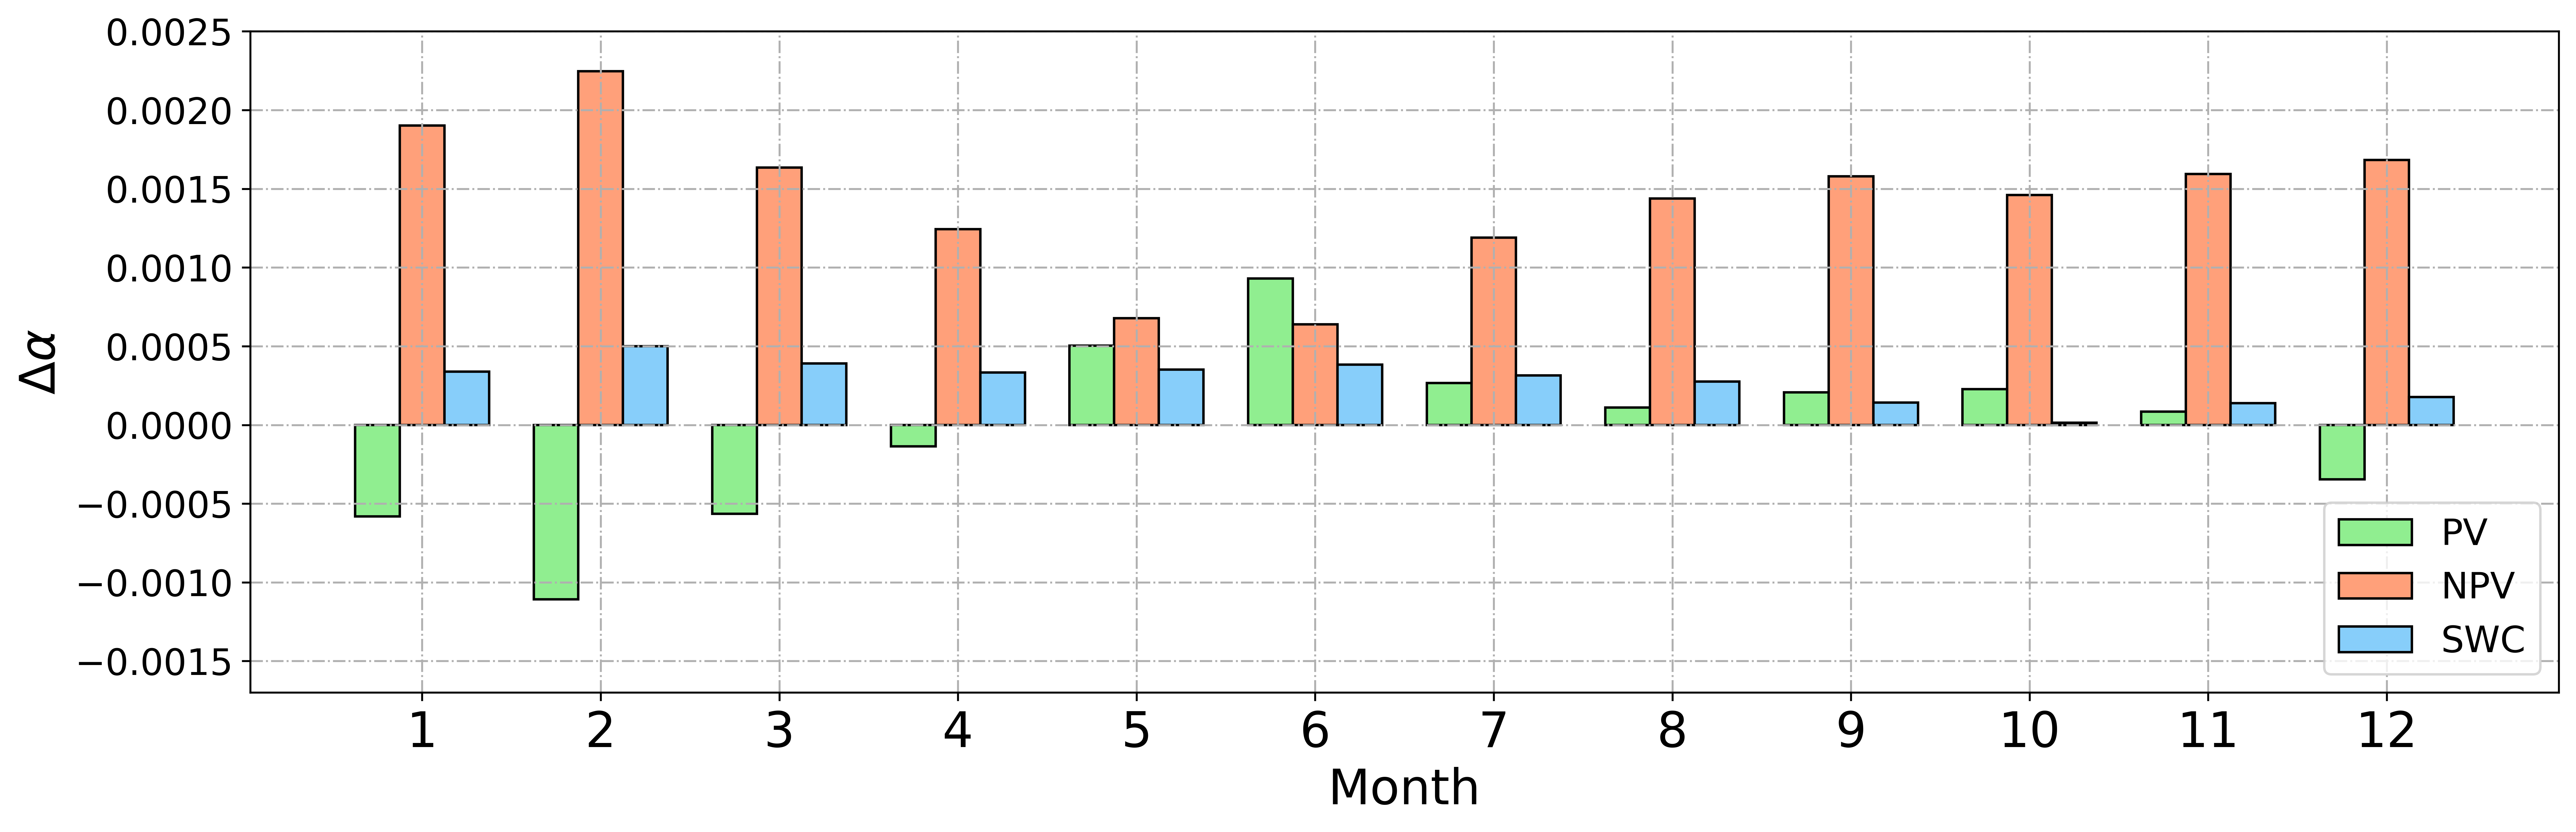

In [2]:
from tool import *

dd=torch.load('/data/hk/albedo/seasons_model_dict.pth')
plt.figure(figsize=(17,5    
                    ),dpi=600)
x = range(12)
plt.grid(linestyle='-.')
plt.bar(x, dd['NDVI'], width=0.25,color='lightgreen',edgecolor='black',label='PV')

# 向右移动0.2, 柱状条宽度为0.2
plt.bar([i + 0.25 for i in x], dd['SSI'], width=0.25, color='lightsalmon',edgecolor='black',label='NPV')
plt.bar([i + 0.5 for i in x], dd['NMDI'], width=0.25, color='lightskyblue',edgecolor='black',label='SWC')
plt.legend()
# 底部汉字移动到两个柱状条中间(本来汉字是在左边蓝色柱状条下面, 向右移动0.1)
plt.xticks([i + 0.25 for i in x], list(range(1,13)),fontsize=20)


plt.legend(fontsize=15)
# plt.xlim(('2001', '2020'))
plt.ylim((-0.0017, 0.0025))
# plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=15)
plt.ylabel(r'$\Delta \alpha$',fontsize=20)
plt.xlabel(r'Month',fontsize=20)
plt.savefig('./figure/season_model.pdf',dpi=600)
plt.show()


In [1]:

cc=[[-1.4691526992812896e-06,
-1.1247133137689813e-05,
-9.002212463589322e-07,
-9.859619227686368e-06,
-4.783103217931371e-06,
1.1589368884997493e-05,
0.0006426714077967431,
-2.4745757309052895e-05,
-6.533866957035596e-06,
-0.00031509541893993704,
-1.6919914346324072e-06,
-0.00028911466123394524,
-4.155196910445207e-06,
-7.598605903621465e-06],

[1.0142205036236784e-05,
-2.792428686650194e-06,
1.375412410995517e-06,
2.529885824831579e-05,
3.7216649397458135e-05,
1.0848126134473804e-06,
-1.3081651384687543e-05,
6.768562220778258e-05,
0.0001419151741309012,
0.0006856025011209687,
7.758735182354997e-06,
0.0004294900296868982,
8.69892871597736e-06,
1.5378097257152277e-05],

[3.900236113951194e-06,
1.756255196083286e-05,
-1.1343609193763025e-06,
5.263182793708876e-06,
1.2791100781701034e-05,
2.116604082001588e-06,
0.00011386317794810984,
2.1294250361515007e-05,
5.068244173985536e-05,
2.9285001639019895e-05,
1.3437237449461452e-06,
2.7023071484028212e-05,
1.0403380594577454e-06,
1.9855683999424054e-06]]

In [2]:
cc_kernel=[[-1.4894701780586133e-06,
-1.1144690999017817e-05,
-9.046183610262279e-07,
-9.694373464519078e-06,
-4.674438021080675e-06,
1.1586475270548671e-05,
0.0006432372531562861,
-2.4685781044769596e-05,
-6.225856445818818e-06,
-0.0003130978868423521,
-1.7044618158722428e-06,
-0.00028687963395705436,
-4.121862595745773e-06,
-7.5534105957075495e-06],
           
[1.0140366073202108e-05,
-2.765758199471375e-06,
1.3692428037790758e-06,
2.5212087993197955e-05,
3.706846853307495e-05,
1.0875338394598605e-06,
-1.3015143524787383e-05,
6.7545631461447e-05,
0.0001416810809175107,
0.000683665552092179,
7.771540620426676e-06,
0.00042715223719061825,
8.662308982776613e-06,
1.5342472671716644e-05],

[3.9072829141940615e-06,
1.7522732044886714e-05,
-1.1258775078869571e-06,
5.299429860053864e-06,
1.2829362585768966e-05,
2.1113327095675074e-06,
0.00011317530880389624,
2.129618756145945e-05,
5.056376857344159e-05,
2.869413699116979e-05,
1.3568252096318999e-06,
2.6957696208911278e-05,
1.0363970236739073e-06,
1.9828323880035517e-06]
]

In [3]:
cc_kernel[1][8]/0.0014960914

0.09470081902583671

In [4]:
0.0006432372531562861/0.0014960914
1.1586475270548671e-05/0.0014960914

0.007744496940861147

In [5]:

all=[4.6946151996962726e-05,
 -0.00012580731709022075,
 -5.222938398219412e-06,
 2.117134863510728e-05,
 7.01916214893572e-05,
 2.4719631255720742e-05,
 0.0009967221412807703,
 0.00011649014777503908,
 0.00024005443265195936,
 0.0007798669976182282,
 2.5903173082042485e-05,
 0.0002533207298256457,
 6.371245490299771e-06,
 1.226629228767706e-05]

In [42]:
[cc[1][i]/all[i]*100 for i in range(14)]

[21.60391130010603,
 2.2196075325631877,
 -26.33407300887214,
 119.49573305105415,
 53.02149830389814,
 4.388466001879894,
 -1.3124672205914731,
 58.10416030932868,
 59.117914450951034,
 87.91274707287906,
 29.952836889059675,
 169.54397296364394,
 136.5341945969825,
 125.36874954953903]

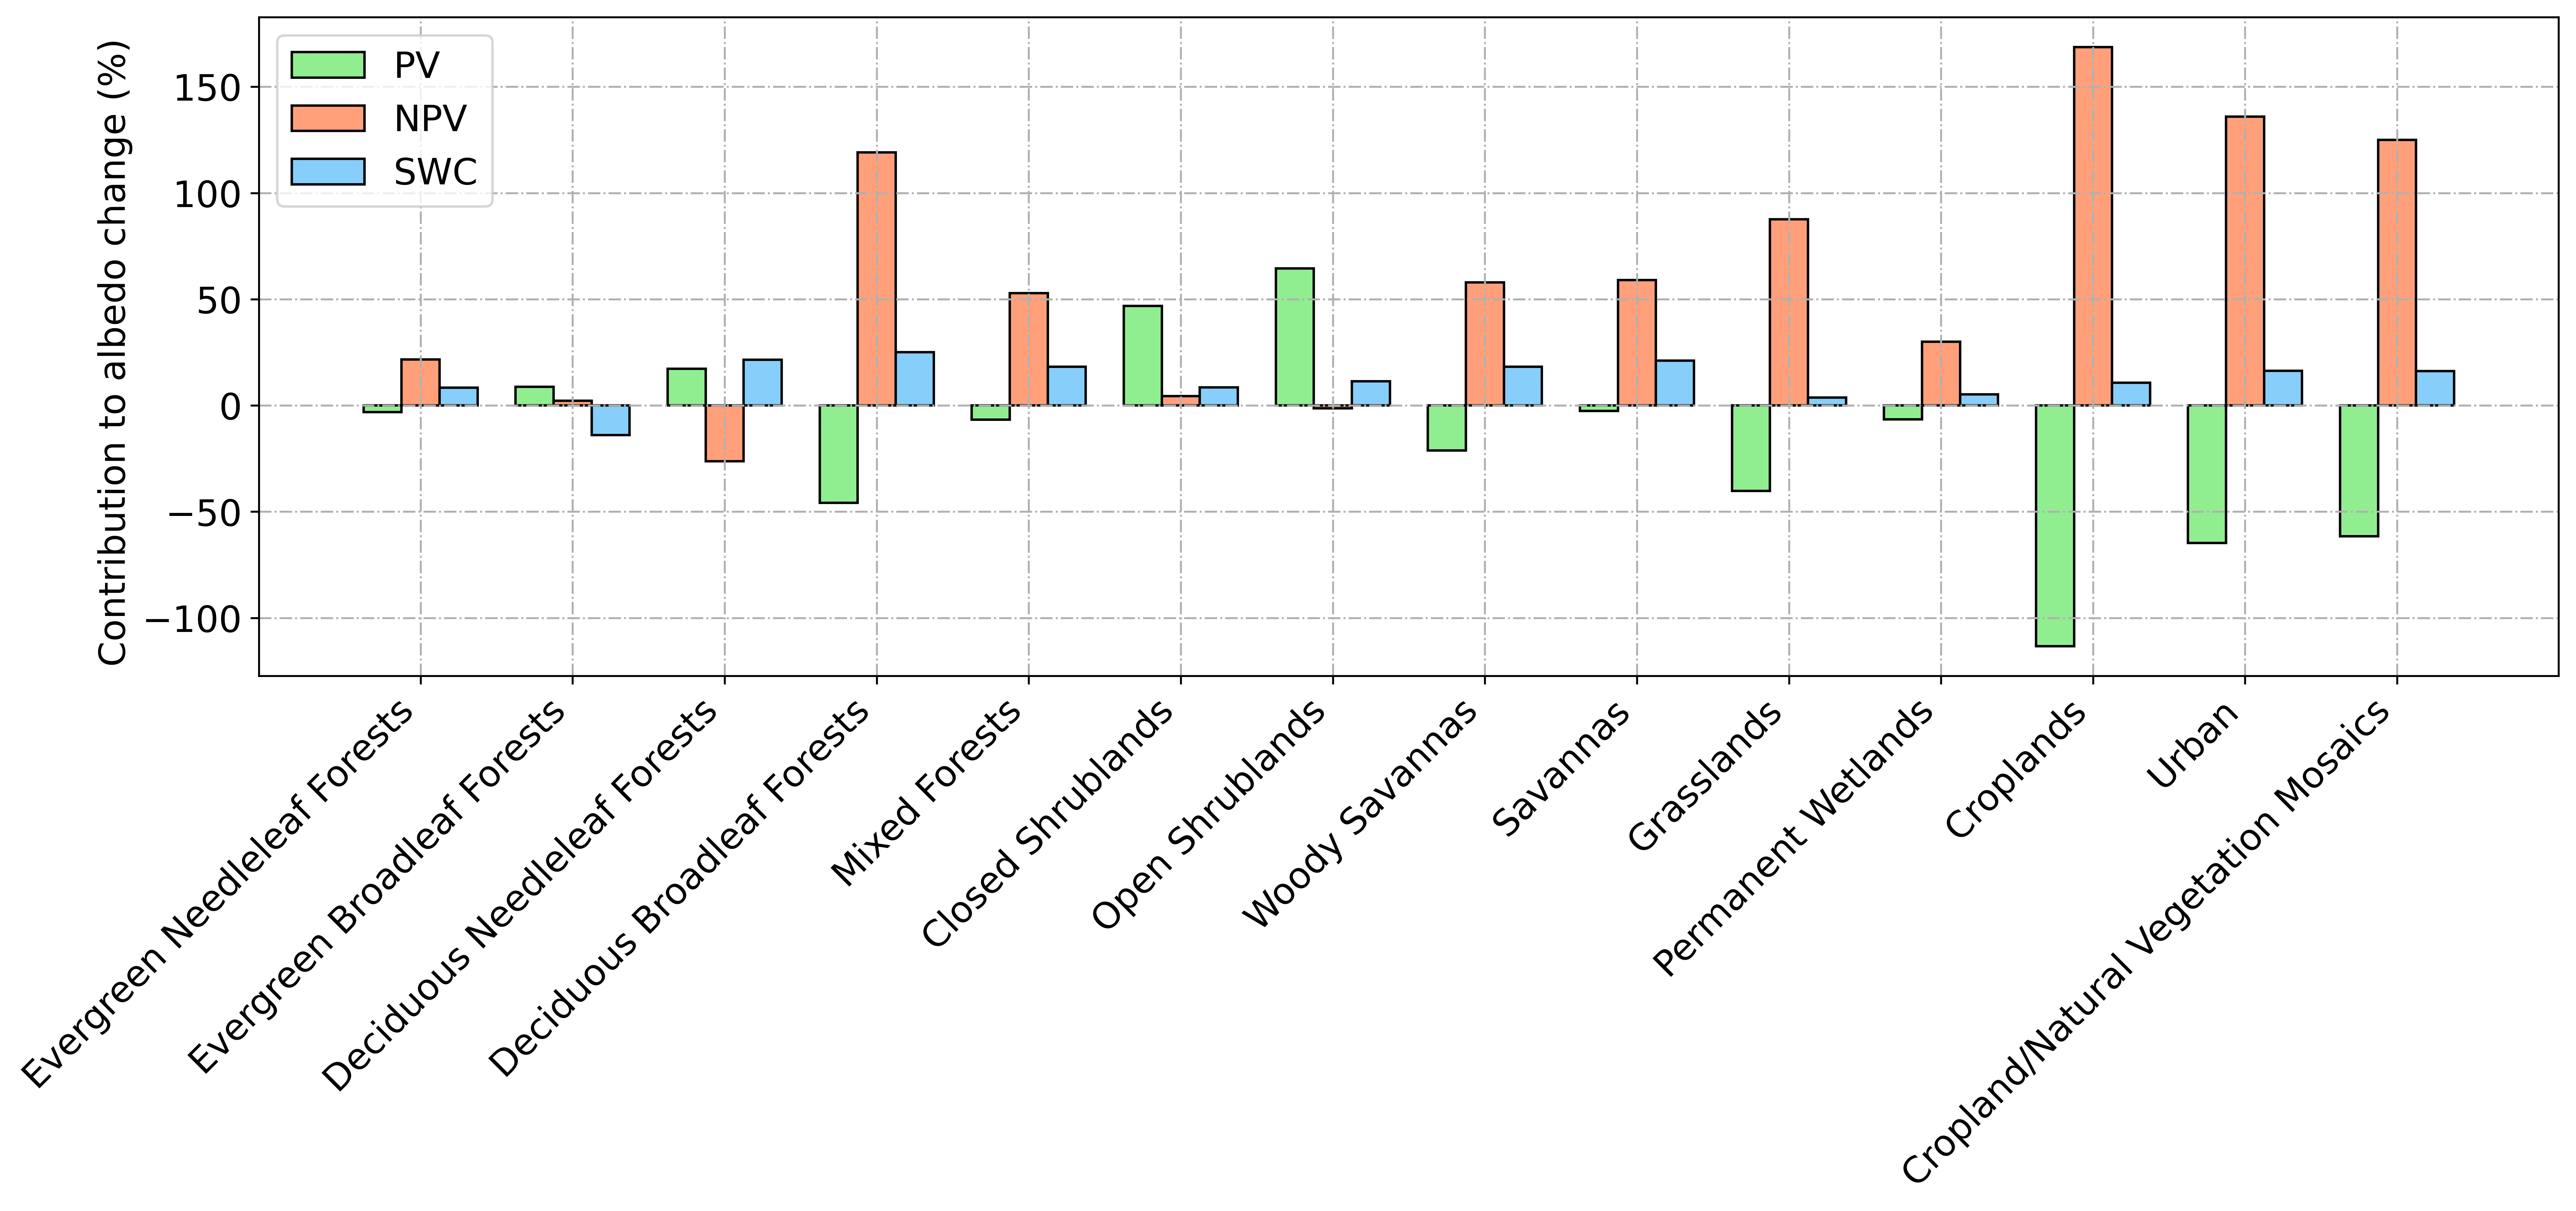

In [5]:
from tool import *
names=['Evergreen Needleleaf Forests',
 'Evergreen Broadleaf Forests',
 'Deciduous Needleleaf Forests',
 'Deciduous Broadleaf Forests',
 'Mixed Forests',
 'Closed Shrublands',
 'Open Shrublands',
 'Woody Savannas',
 'Savannas',
 'Grasslands',
 'Permanent Wetlands',
 'Croplands',
 'Urban',
 'Cropland/Natural Vegetation Mosaics']
dd=torch.load('/data/hk/albedo/seasons_model_dict.pth')
plt.figure(figsize=(17,5    
                    ),dpi=600)
x = range(14)
plt.grid(linestyle='-.')
plt.bar(x, [cc_kernel[0][i]/all[i]*100 for i in range(14)], width=0.25,color='lightgreen',edgecolor='black',label='PV')

# 向右移动0.2, 柱状条宽度为0.2
plt.bar([i + 0.25 for i in x], [cc_kernel[1][i]/all[i]*100 for i in range(14)], width=0.25, color='lightsalmon',edgecolor='black',label='NPV')
plt.bar([i + 0.5 for i in x], [cc_kernel[2][i]/all[i]*100 for i in range(14)], width=0.25, color='lightskyblue',edgecolor='black',label='SWC')
plt.legend()
# 底部汉字移动到两个柱状条中间(本来汉字是在左边蓝色柱状条下面, 向右移动0.1)
plt.xticks([i + 0.25 for i in x], names,fontsize=15,rotation=45,horizontalalignment='right')


plt.legend(fontsize=15)
# plt.xlim(('2001', '2020'))
# plt.ylim((-0.0017, 0.0025))
# plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=15)
plt.ylabel(r'Contribution to albedo change (%) ',fontsize=15)
# plt.xlabel(r'Month',fontsize=20)
plt.savefig('./figure/type_model_kernel.pdf',dpi=600)
plt.show()


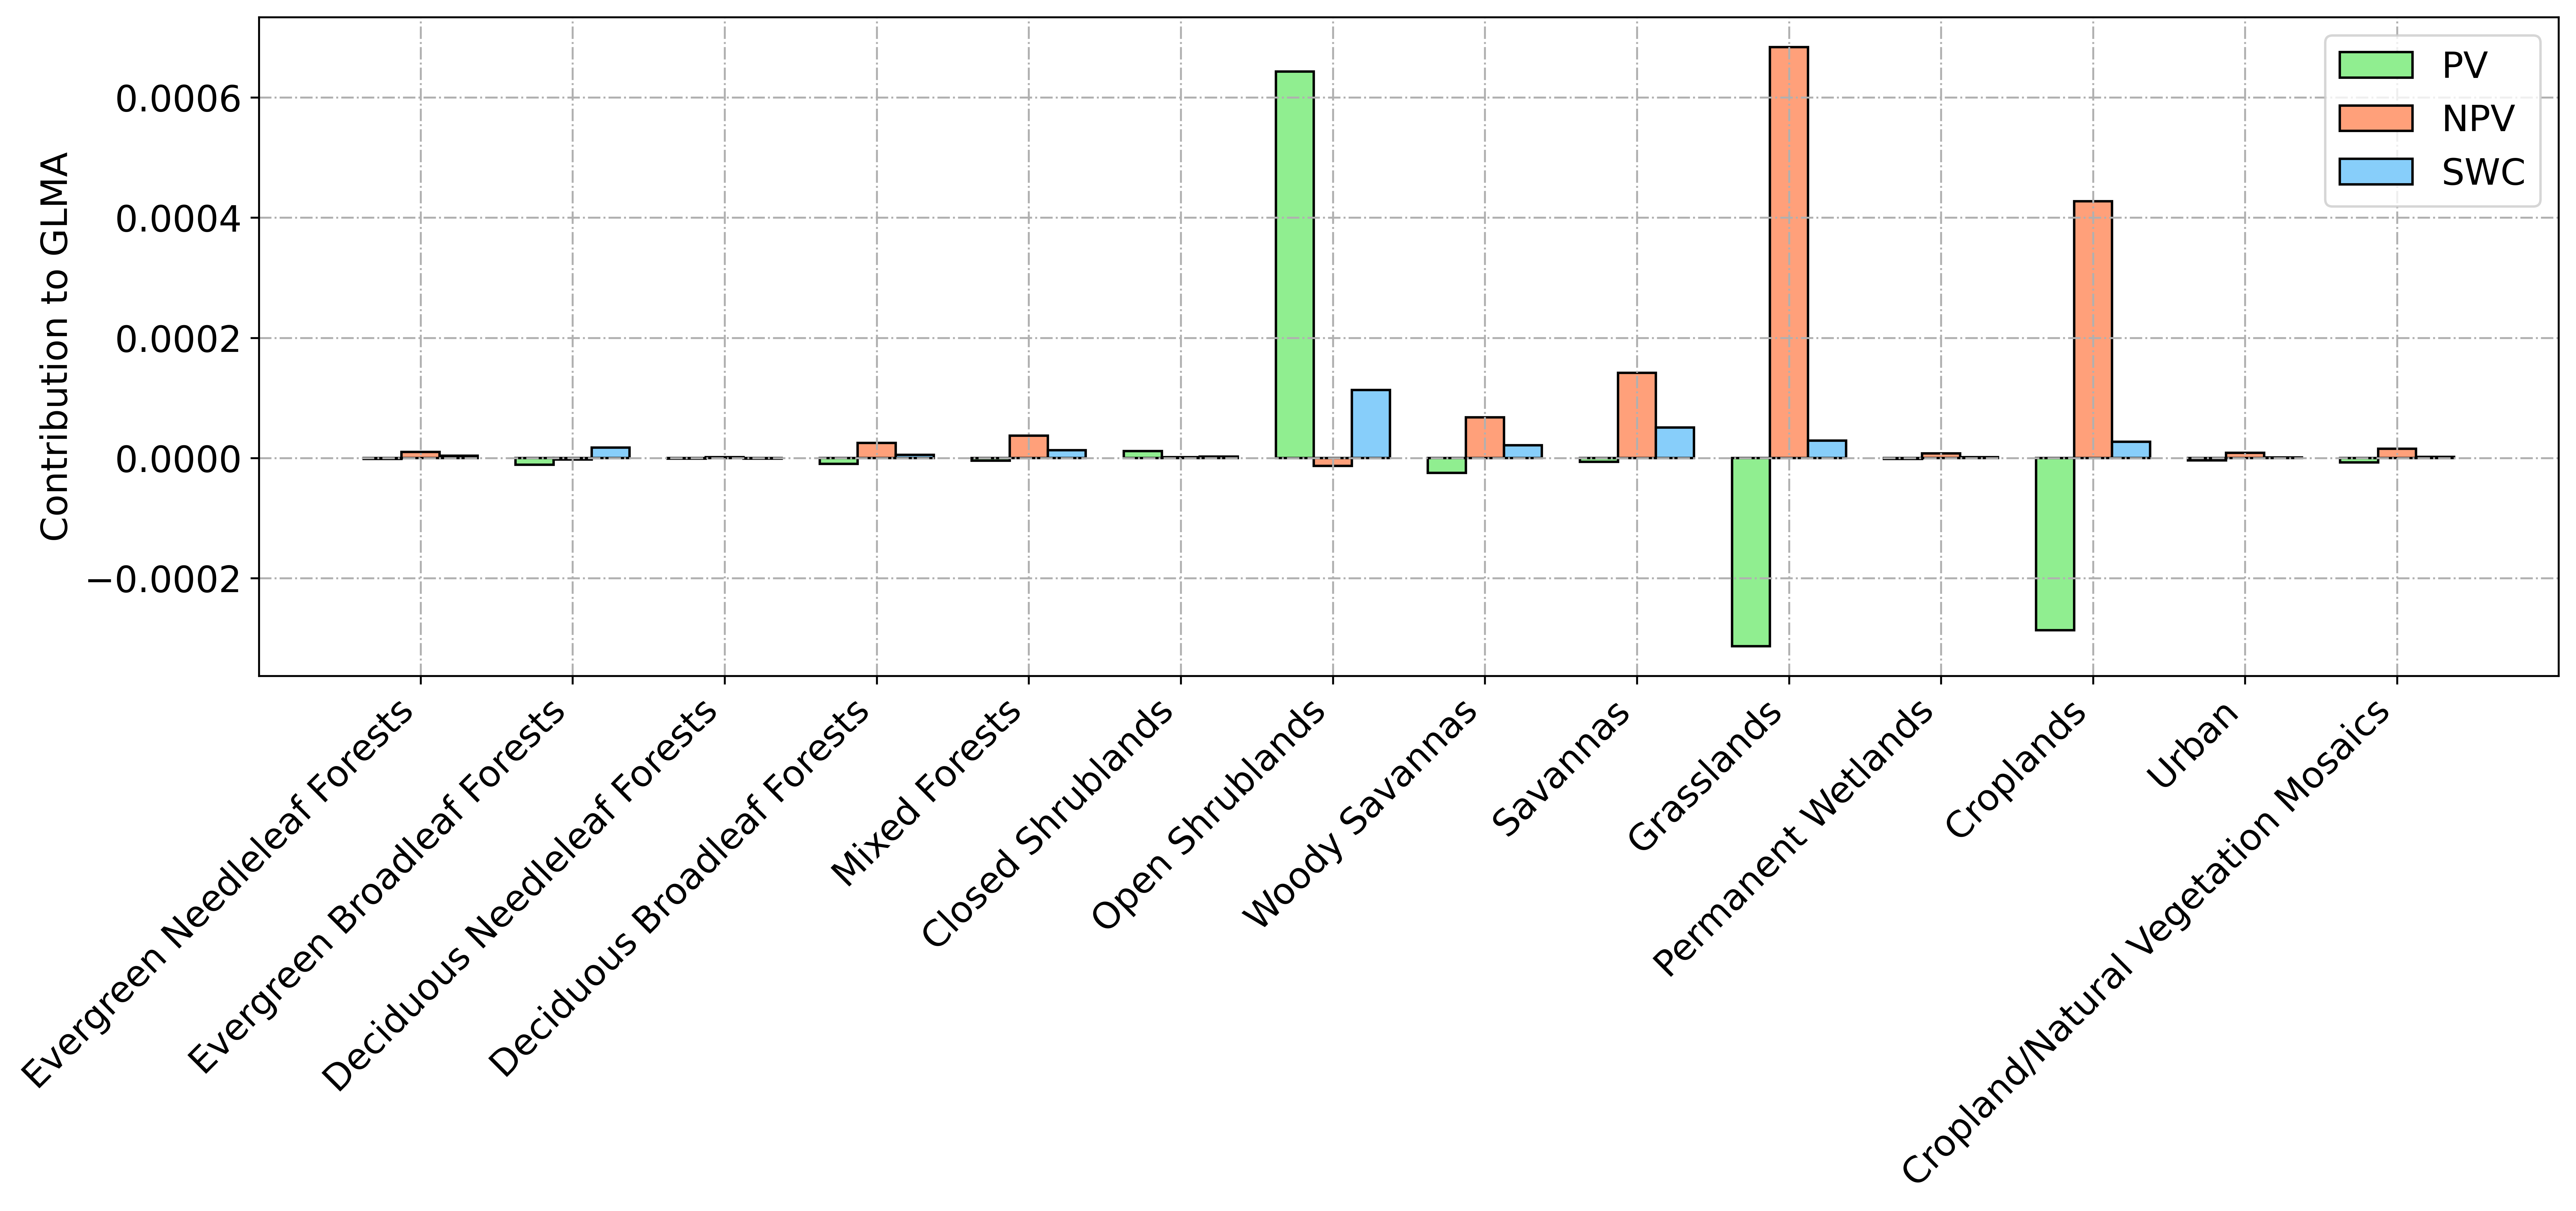

In [7]:
from tool import *
names=['Evergreen Needleleaf Forests',
 'Evergreen Broadleaf Forests',
 'Deciduous Needleleaf Forests',
 'Deciduous Broadleaf Forests',
 'Mixed Forests',
 'Closed Shrublands',
 'Open Shrublands',
 'Woody Savannas',
 'Savannas',
 'Grasslands',
 'Permanent Wetlands',
 'Croplands',
 'Urban',
 'Cropland/Natural Vegetation Mosaics']
dd=torch.load('/data/hk/albedo/seasons_model_dict.pth')
plt.figure(figsize=(17,5    
                    ),dpi=600)
x = range(14)
plt.grid(linestyle='-.')
plt.bar(x, cc_kernel[0], width=0.25,color='lightgreen',edgecolor='black',label='PV')

# 向右移动0.2, 柱状条宽度为0.2
plt.bar([i + 0.25 for i in x], cc_kernel[1], width=0.25, color='lightsalmon',edgecolor='black',label='NPV')
plt.bar([i + 0.5 for i in x], cc_kernel[2], width=0.25, color='lightskyblue',edgecolor='black',label='SWC')
plt.legend()
# 底部汉字移动到两个柱状条中间(本来汉字是在左边蓝色柱状条下面, 向右移动0.1)
plt.xticks([i + 0.25 for i in x], names,fontsize=15,rotation=45,horizontalalignment='right')


plt.legend(fontsize=15)
# plt.xlim(('2001', '2020'))
# plt.ylim((-0.0017, 0.0025))
# plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=15)
plt.ylabel(r'Contribution to GLMA',fontsize=15)
# plt.xlabel(r'Month',fontsize=20)
plt.savefig('./figure/type_model2_kernel.pdf',dpi=600)
plt.show()


In [1]:
pip install ternary

  Preparing metadata (setup.py) ... done
  Created wheel for ternary: filename=ternary-0.1-py3-none-any.whl size=1779 sha256=a28fd01cf394e5658c90317415f9724f692c00d613d77f39cefaa9908b6c1b6e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a4/ea/76/f488a1b431a25c84eee0c81a6ee5d2229c822bcd8c2daa5b0f
Successfully built ternary
Note: you may need to restart the kernel to use updated packages.


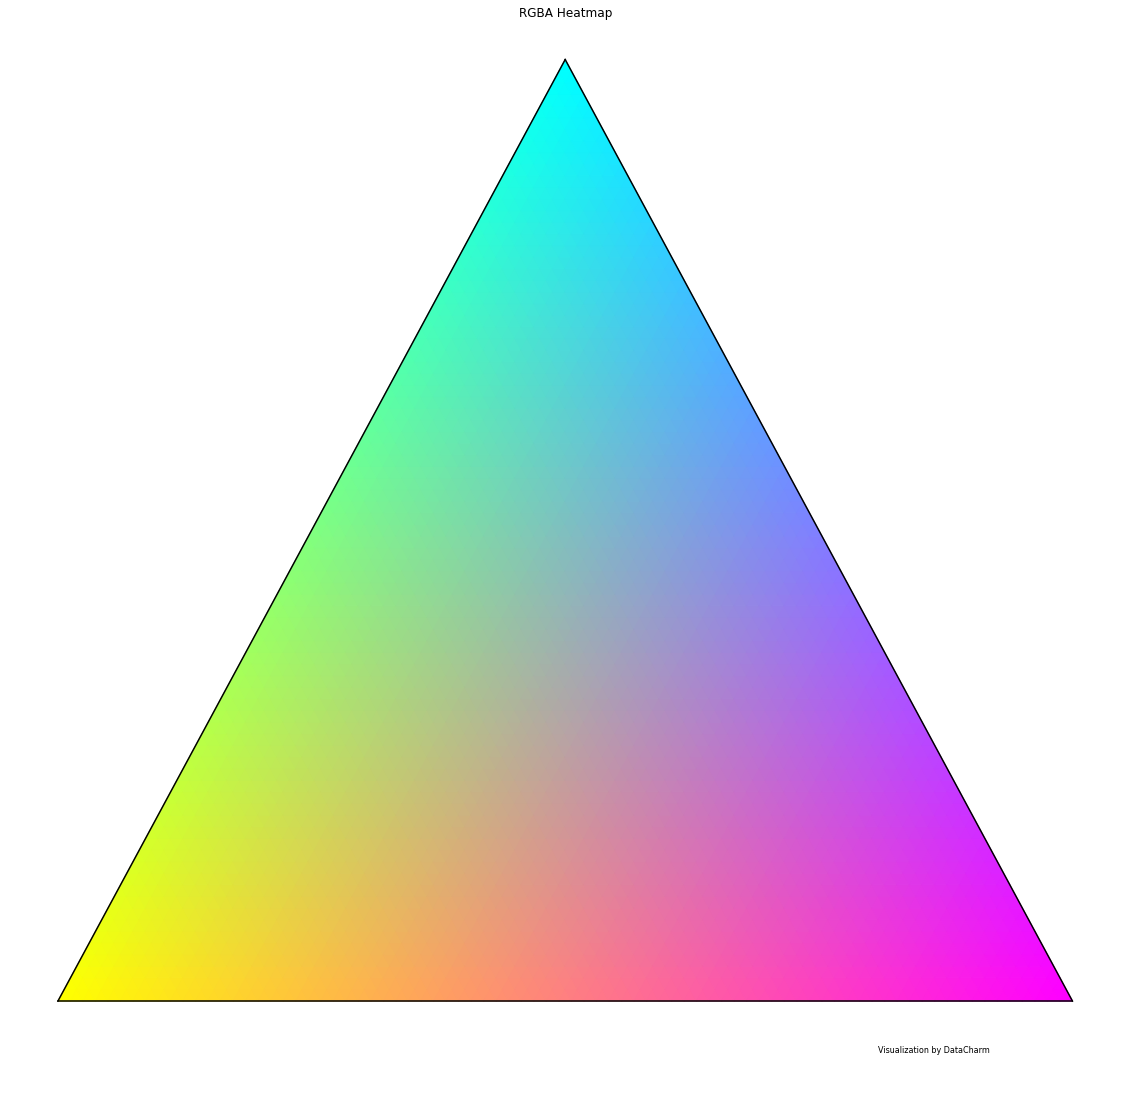

<Figure size 3600x2400 with 0 Axes>

In [22]:
import math
import ternary
from tool import *
def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    k=[1,0,0]
    r = (w-k[0]*y_color-k[1]*x_color-k[2]*z_color) / w
    g = (w-k[0]*x_color-k[1]*y_color-k[2]*z_color) / w
    b = (w-k[0]*z_color-k[1]*x_color-k[2]*y_color) / w
    return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

fig,ax = plt.subplots()
scale = 80
data = generate_heatmap_data(scale)
plt.figure(dpi=600)
figure, tax = ternary.figure(scale=scale,ax=ax)
figure.set_size_inches(20, 20)

tax.heatmap(data,style='dual_triangular', use_rgba=True, colorbar=False)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
ax.text(.83,.06,'\nVisualization by DataCharm',transform = ax.transAxes,
        ha='center', va='center',fontsize = 8,color='black')
plt.savefig('./figure/triangle.png',dpi=600)
plt.show()

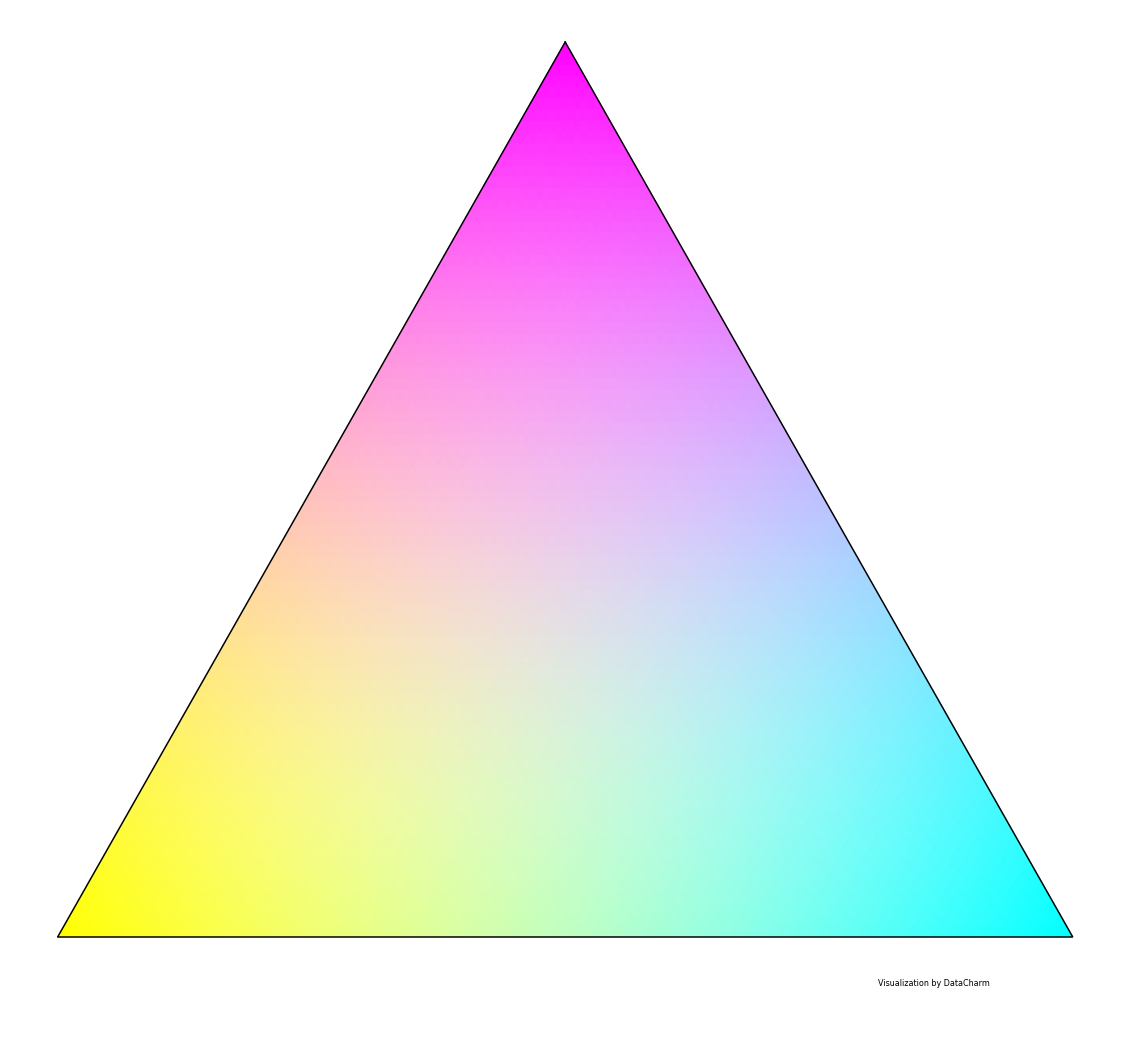

<Figure size 3600x2400 with 0 Axes>

In [5]:
import math
import ternary
from tool import *
def color_point_r(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    k=[1,0,0]
    r1 = math.fabs(w-k[0]*x_color-k[1]*y_color-k[2]*z_color) / w
    g1 = math.fabs(w) / w
    b1 = math.fabs(w) / w
    a1=math.fabs(x_color) / w
    
    r2 = math.fabs(w) / w
    g2 = math.fabs(w-k[0]*y_color-k[1]*x_color-k[2]*z_color) / w
    b2 = math.fabs(w) / w
    a2=math.fabs(y_color) / w    
    
    r3 = math.fabs(w) / w
    g3 = math.fabs(w) / w
    b3 = math.fabs(w-k[0]*z_color-k[1]*x_color-k[2]*y_color) / w
    a3=math.fabs(z_color) / w  
    r=r1*a1+r2*a2+r3*a3
    b=b1*a1+b2*a2+b3*a3
    g=g1*a1+g2*a2+g3*a3
    return (r, g, b, 1)


def generate_heatmap_data_r(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point_r(i, j, k, scale)
    return d

fig,ax = plt.subplots()
scale = 80
data_r = generate_heatmap_data_r(scale)
plt.figure(dpi=600)
figure, tax = ternary.figure(scale=scale,ax=ax)
figure.set_size_inches(20, 19)
tax.heatmap(data_r, style="triangular", use_rgba=True, colorbar=False)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
# tax.set_title("RGBA Heatmap")
ax.text(.83,.06,'\nVisualization by DataCharm',transform = ax.transAxes,
        ha='center', va='center',fontsize = 8,color='black')
figure.savefig('./figure/triangle.pdf',dpi=600)
plt.show()

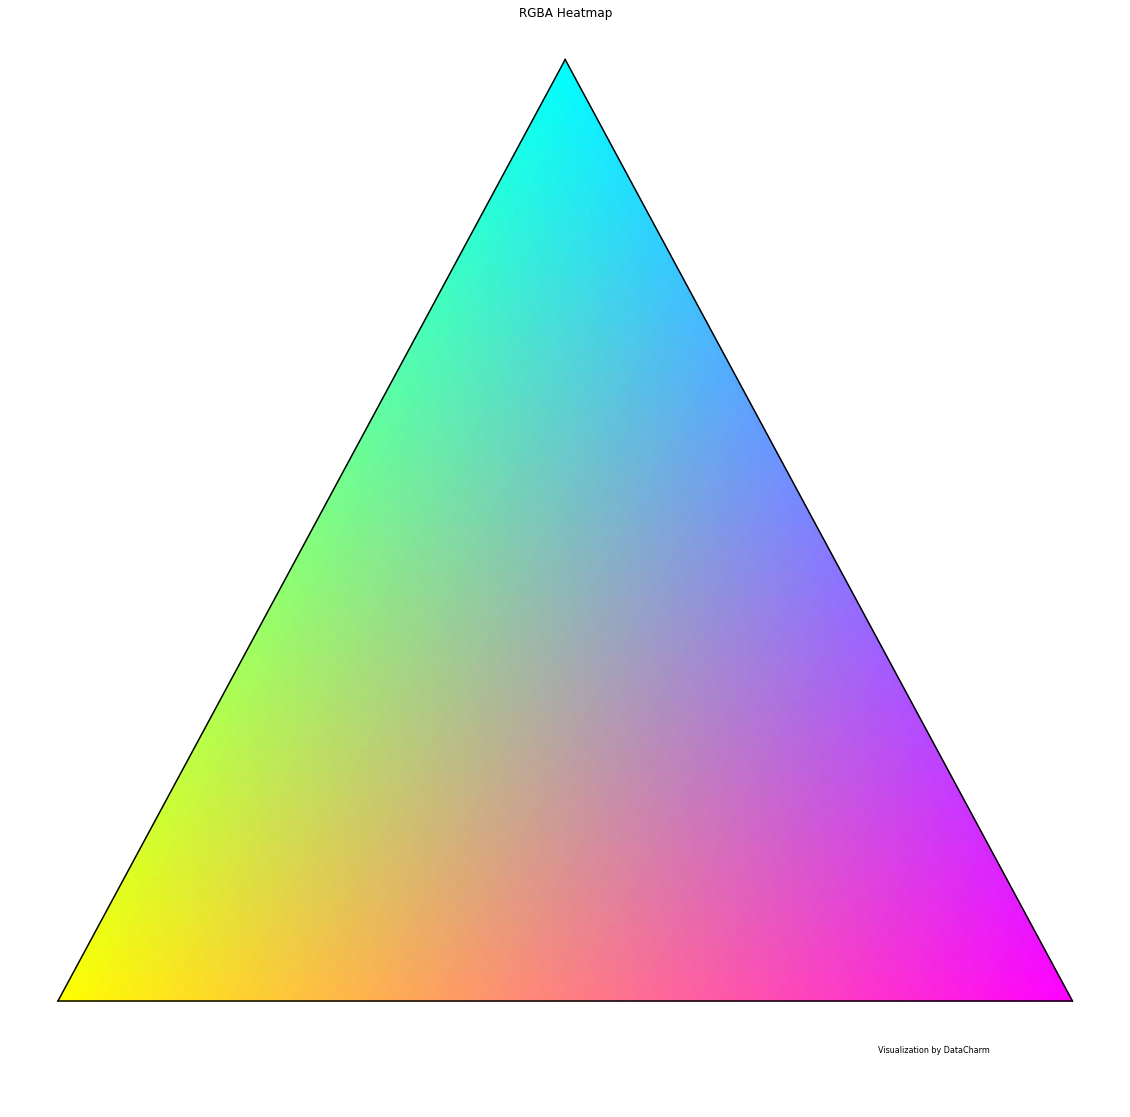

<Figure size 3600x2400 with 0 Axes>

In [4]:
import math
import ternary
from tool import *
def color_point(x, y, z, scale):
    w = 255
    x_color = (x * w / float(scale))
    y_color = (y * w / float(scale))
    z_color = (z * w / float(scale))
    k=[1,0,0]
    r = (w-k[0]*y_color-k[1]*x_color-k[2]*z_color) / w
    g = (w-k[0]*x_color-k[1]*y_color-k[2]*z_color) / w
    b = (w-k[0]*z_color-k[1]*x_color-k[2]*y_color) / w
    return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

fig,ax = plt.subplots()
scale = 80
data = generate_heatmap_data(scale)
plt.figure(dpi=600)
figure, tax = ternary.figure(scale=scale,ax=ax)
figure.set_size_inches(20, 20)

tax.heatmap(data,style='hexagonal', use_rgba=True, colorbar=False)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
ax.text(.83,.06,'\nVisualization by DataCharm',transform = ax.transAxes,
        ha='center', va='center',fontsize = 8,color='black')
figure.savefig('./figure/triangle.png',dpi=600)
plt.show()

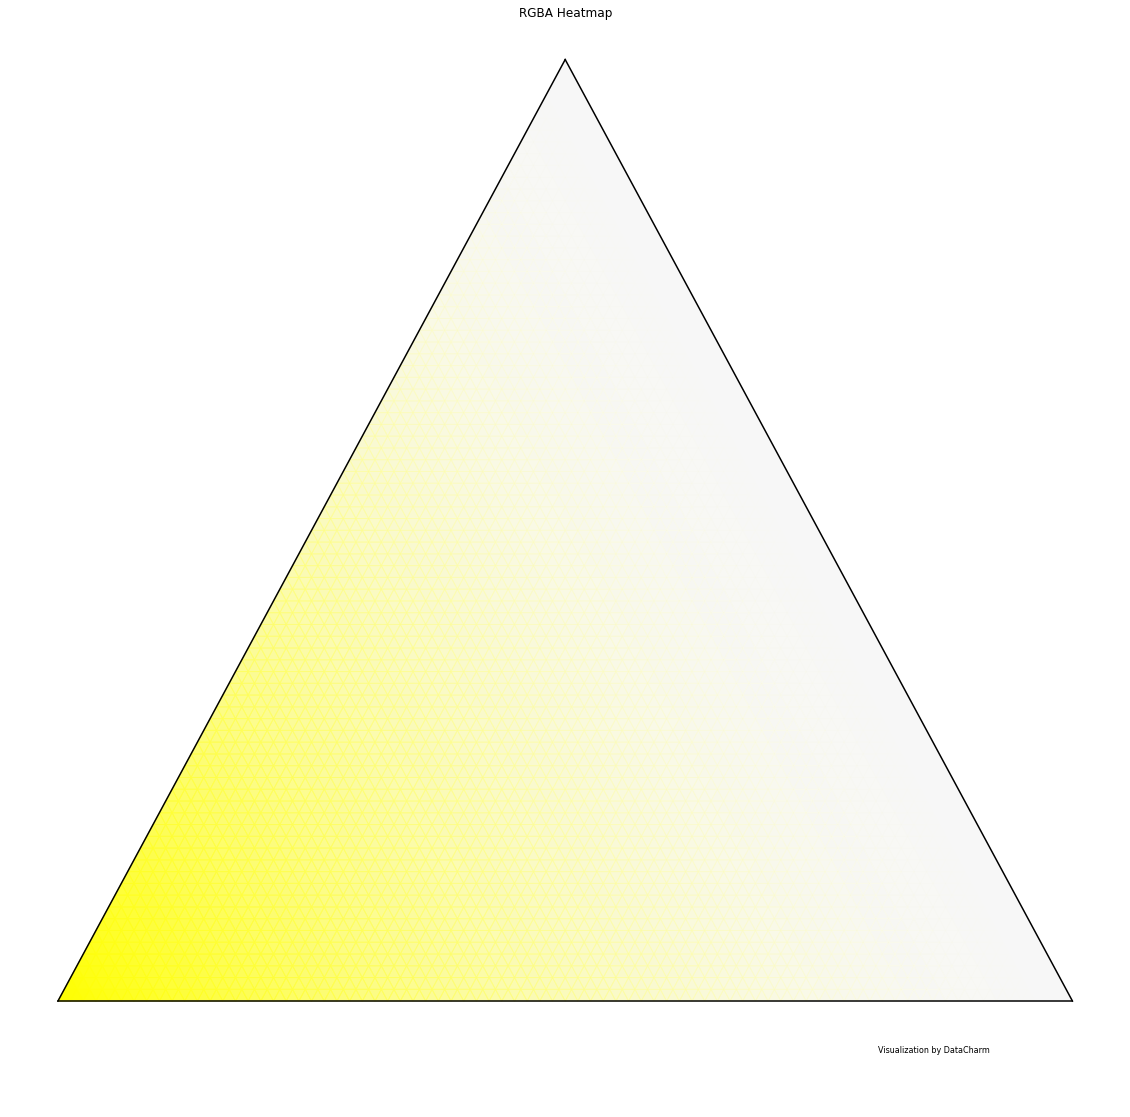

<Figure size 3600x2400 with 0 Axes>

In [31]:
import math
import ternary
from tool import *
def color_point_r(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    k=[1,0,0]
    r = math.fabs(w-k[0]*y_color-k[1]*x_color-k[2]*z_color) / w
    g = math.fabs(w) / w
    b = math.fabs(w) / w
    a=math.fabs(y_color) / w
    return (r, g, b, a)
def color_point_g(y, x, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    k=[1,0,0]
    g = math.fabs(w-k[0]*y_color-k[1]*x_color-k[2]*z_color) / w
    r = math.fabs(w) / w
    b = math.fabs(w) / w
    a=math.fabs(y_color) / w
    return (r, g, b, a)
def color_point_b(x, z, y, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    k=[1,0,0]
    b = math.fabs(w-k[0]*y_color-k[1]*x_color-k[2]*z_color) / w
    g = math.fabs(w) / w
    r = math.fabs(w) / w
    a=math.fabs(y_color) / w
    return (r, g, b, a)

def generate_heatmap_data_r(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point_r(i, j, k, scale)
    return d
def generate_heatmap_data_g(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point_g(i, j, k, scale)
    return d
def generate_heatmap_data_b(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point_b(i, j, k, scale)
    return d

fig,ax = plt.subplots()
scale = 80
data_r = generate_heatmap_data_r(scale)
data_g = generate_heatmap_data_g(scale)
data_b = generate_heatmap_data_b(scale)
plt.figure(dpi=600)
figure, tax = ternary.figure(scale=scale,ax=ax)
figure.set_size_inches(20, 20)

tax.heatmap(data_b, style="triangular", use_rgba=True, colorbar=False)
tax.heatmap(data_g, style="triangular", use_rgba=True, colorbar=False)
tax.heatmap(data_r, style="triangular", use_rgba=True, colorbar=False)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
ax.text(.83,.06,'\nVisualization by DataCharm',transform = ax.transAxes,
        ha='center', va='center',fontsize = 8,color='black')
plt.savefig('./figure/triangle.png',dpi=600)
plt.show()